In [2]:
import numpy as np
import pandas as pd
import json

import matplotlib 
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import GridSearchCV

import seaborn as sns


import time

plt.style.use('seaborn-white')
sns.set_theme(style="whitegrid")
sns.set_style("whitegrid", {'legend.frameon':True})

/tmp/ipykernel_4449/583203746.py:21: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


In [3]:
from dataclasses import dataclass


@dataclass
class OutputData:
    features: pd.DataFrame
    output: pd.DataFrame


def get_dataset(path: str):
    f = open(path)
    data = json.load(f)
    f.close()
    return data

In [29]:
# json_dataset = get_dataset('./datasets/linear/data_25_000.json') +\
#             get_dataset('./datasets/linear/data_30_000.json') +\
#             get_dataset('./datasets/linear/data_35_000.json') +\
#             get_dataset('./datasets/linear/data_50_000.json') +\
#             get_dataset('./datasets/linear/data_55_000.json') +\
#             get_dataset('./datasets/linear/data_150_000.json')   
json_dataset = get_dataset('./datasets/linear/data_10_000_32.json') +\
               get_dataset('./datasets/linear/data_40_000_32.json') 
df = pd.json_normalize(json_dataset)

columns_rename = {
    ## service params
    'inp.services.cv': 'services_cv',
    'inp.services.skew': 'services_skew',
    'inp.services.rate_min': 'services_rate_min',
    'inp.services.rate_max': 'services_rate_max',
    ## arrival params
    'inp.arrival.skew': 'arrival_skew',
    'inp.arrival.cv': 'arrival_cv',
    'inp.arrival.rate': 'arrival_rate',
    ## num servers
    'inp.num_servers': 'num_servers',
    ## capacity
    'inp.capacity': 'capacity',
    ## meta info
    'meta.fitted.arrival_cv': 'meta_arrival_cv',
    'meta.fitted.arrival_skew': 'meta_arrival_skew',
    'meta.fitted.arrival_lag': 'meta_arrival_lag',
    'meta.fitted.arrival_cv': 'meta_arrival_cv',
    'meta.fitted.arrival_order': 'meta_arrival_order',
    'meta.fitted.service_cv': 'meta_service_cv',
    'meta.fitted.service_skew': 'meta_service_skew',
    'meta.fitted.service_order': 'meta_service_order',
    ## output
    'out.max_system_size.avg': 'out_max_system_size_avg',
    'out.max_system_size.std': 'out_max_system_size_std',
    'out.max_system_size.index': 'out_max_system_size_index',
    'out.min_system_size.avg': 'out_min_system_size_avg',
    'out.min_system_size.std': 'out_min_system_size_std',
    'out.min_system_size.index': 'out_min_system_size_index',
    'out.max_busy_rate.avg': 'out_max_busy_rate_avg',
    'out.max_busy_rate.std': 'out_max_busy_rate_std',
    'out.max_busy_rate.index': 'out_max_busy_rate_index',
    'out.min_busy_rate.avg': 'out_min_busy_rate_avg',
    'out.min_busy_rate.std': 'out_min_busy_rate_std',
    'out.min_busy_rate.index': 'out_min_busy_rate_index',
    'out.loss_prob': 'out_los_prob',
    'out.response_time.avg': 'out_response_time_avg',
    'out.response_time.std': 'out_response_time_std',
    'out.response_time.index': 'out_response_time_index'
}

df = df.rename(columns=columns_rename, inplace=False)
df = df.loc[df['out_response_time_avg'] < 20]
df = df.loc[df['meta_arrival_skew'] < 100]
df = df.loc[df['meta_service_skew'] < 100]

data = OutputData(
    features=df[[
                 'meta_service_skew', 
                 'services_rate_min', 
                 'services_rate_max',
                 'meta_arrival_skew',
                 'arrival_rate',
                 'num_servers',
                 'capacity'
    ]],
    output=df[['out_response_time_avg',
               'out_min_busy_rate_avg',
               'out_max_busy_rate_avg',
               'out_los_prob',
               'out_max_system_size_avg',
               'out_min_system_size_avg',
    ]]
)

## TODO remove input_type and lag from df
data

OutputData(features=       meta_service_skew services_rate_min services_rate_max  \
0                  61.20             29.55             35.28   
1                  79.69             32.00             48.71   
2                  12.60              5.98             44.92   
3                  78.71              9.20             19.00   
4                  76.80              2.73             48.25   
...                  ...               ...               ...   
49983               0.56             16.84             32.30   
49984              82.26              4.48             19.09   
49985              63.39             24.57             45.98   
49986              23.69              9.67             24.79   
49987              81.44              9.51             11.15   

       meta_arrival_skew arrival_rate  num_servers  capacity  
0                  42.29        26.39            4        14  
1                  88.47        31.05            4         5  
2                  96.

In [30]:
COLORS_MAP = {
    'green': ["Greens", 'lightgreen'],
    'blue': ["Blues", 'lightblue'],
    'orange': ["Oranges", "#fed8b1"],
    'purple': ['Purples', '#D8BFD8']
}


def build_estimates_tests_scatter(estimations, predictions,
                                  name="", 
                                  rang=[0, 10], 
                                  divider=1,
                                  xlabel='samples_s', 
                                  ylabel='sstimates_s',
                                  color='blue'):
    
    fig , ax = plt.subplots(figsize=(6, 6))
    cm = plt.get_cmap(COLORS_MAP.get(color)[0])
    col = [cm(1 / abs(predictions[i] - estimations[i])/divider) for i in range(len(estimations))]
    plt.scatter(predictions, estimations, c=col, marker='^')
    x = np.linspace(rang[0], rang[1])
    plt.plot(x, x, linestyle='-', linewidth=2, color=COLORS_MAP.get(color)[1])
    plt.title('{}'.format(name), fontsize=22, pad=10)
    ax.title.set_fontsize(24)
    plt.xticks()
    plt.tick_params(labelsize=22)
    plt.yticks()

    plt.xlim(rang)
    plt.ylim(rang)

    ax.set_xlabel(xlabel, size=24)
    ax.set_ylabel(ylabel, size=24)

## response time regression

In [31]:
response_time = data.output['out_response_time_avg']
response_time

0        0.349017
1        0.169287
2        0.973574
3        0.490732
4        2.175073
           ...   
49983    0.159470
49984    2.854592
49985    0.212342
49986    0.238779
49987    3.275122
Name: out_response_time_avg, Length: 49098, dtype: float64

In [32]:
data.features

,meta_service_skew,services_rate_min,services_rate_max,meta_arrival_skew,arrival_rate,num_servers,capacity
0,61.20,29.55,35.28,42.29,26.39,4,14
1,79.69,32.00,48.71,88.47,31.05,4,5
2,12.60,5.98,44.92,96.78,22.23,11,4
3,78.71,9.20,19.00,51.46,2.43,20,16
4,76.80,2.73,48.25,62.84,5.96,18,5
...,...,...,...,...,...,...,...
49983,0.56,16.84,32.30,62.43,11.18,9,4
49984,82.26,4.48,19.09,50.76,29.85,22,12
49985,63.39,24.57,45.98,82.01,19.71,23,13
49986,23.69,9.67,24.79,57.61,2.58,28,15


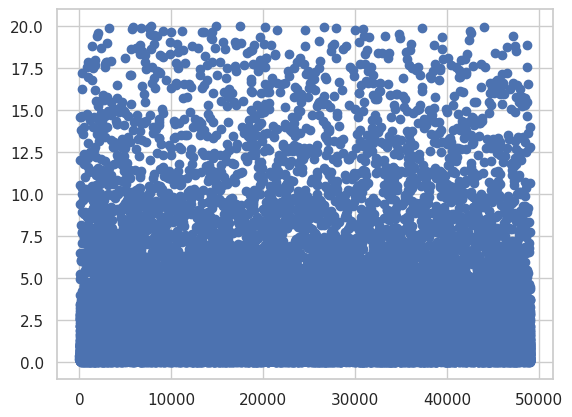

In [33]:
d = response_time
y = list(float(i) for i in d)
x = range(0, len(y))
plt.scatter(x, y)

## Regression tree

In [34]:
# decision tree regressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

tree_params = {
                'criterion': ['mse', 'mae'],
                'max_depth':[4,6,8,9,10,15,20]
}

gs = GridSearchCV(
    DecisionTreeRegressor(random_state=0),
    tree_params,
    verbose=1,
    cv=10,
    n_jobs=4
)

#regressor = DecisionTreeRegressor(random_state=0)
#cross_val_score(regressor, df, y_busy_services, cv=10)

#gs.fit(df, y_busy_services)

start_time = time.time()
tree = DecisionTreeRegressor(criterion='absolute_error', max_depth=12)
print("Time for calculation decision tree {}".format(time.time() - start_time))

scaler = StandardScaler()
scaler.fit(data.features)
features = scaler.transform(data.features)

X_train, X_test, y_train, y_test = train_test_split(features, response_time, train_size=0.8)

tree.fit(X_train, y_train)
#print(regression_report(y_test, tree.predict(X_test)))

Time for calculation decision tree 2.5510787963867188e-05


DecisionTreeRegressor(criterion='absolute_error', max_depth=12)

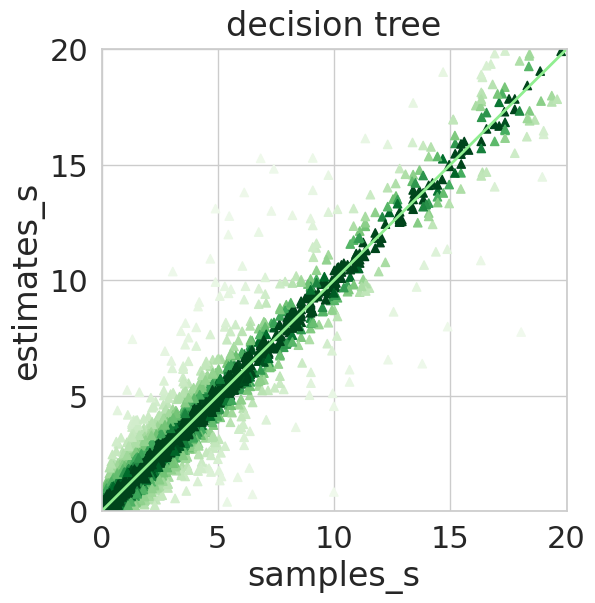

In [36]:
build_estimates_tests_scatter(
    y_test.values,
    tree.predict(X_test), 
    name="decision tree", 
    color="green",
    rang=[0, 20], divider=2, 
    xlabel="samples_s", 
    ylabel="estimates_s"
)

## Gradient boosting

In [47]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data.features, response_time, train_size=0.8, random_state=42)
#grb_estimation_pipe = make_pipeline(StandardScaler(), GradientBoostingRegressor(max_depth=18, n_estimators=1000))

grb_estimation_pipe = GradientBoostingRegressor()

tree_params = {
    'loss': ['squared_error', 'absolute_error', 'huber'],
    'criterion': ['squared_error', 'firedman_mse'],
    'max_depth': [4, 6, 8],
    'n_estimators': [400, 600, 800]
}

start_time = time.time()
#grb_estimation_pipe.fit(X_train, y_train) 

gs = GridSearchCV(
    grb_estimation_pipe,
    param_grid=tree_params,
    n_jobs=6,
    cv=4
)

gs.fit(X_train, y_train)

print(gs.best_params_)
print(gs.best_score_)

#print("Time for calculation gradient boosting {}".format(time.time() - start_time))

/home/aleksandr/Projects/queues-fork-join/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
108 fits failed out of a total of 216.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
108 fits failed with the following error:
Traceback (most recent call last):
  File "/home/aleksandr/Projects/queues-fork-join/venv/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/aleksandr/Projects/queues-fork-join/venv/lib/python3.10/site-packages/sklearn/base.py", line 1144, in wrapper
    estimator._validate_params()
  File "/home/aleksandr/Projects/queues-fork-join/venv/lib/python3.10/site-packages/

{'criterion': 'squared_error', 'loss': 'squared_error', 'max_depth': 4, 'n_estimators': 600}
0.9620231163143694


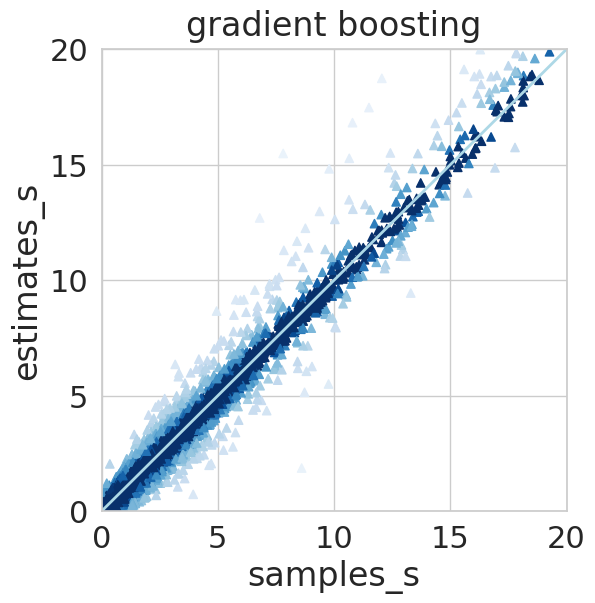

In [48]:
build_estimates_tests_scatter(
    y_test.values,
    gs.predict(X_test), 
    name="gradient boosting", 
    color="blue",
    rang=[0, 20], divider=2, 
    xlabel="samples_s", 
    ylabel="estimates_s"
)

In [67]:
scaler = StandardScaler()
scaler.fit(X_test)
x = scaler.transform(X_test)
print(x)
X_test

[[ 0.762432   -0.22064914 -1.24709817 ...  1.37699073 -0.60014601
  -0.34159152]
 [-2.89199857  1.15101036  0.934523   ... -0.1202556  -1.01553309
   0.79003224]
 [ 0.26025483 -0.27229805 -0.36728846 ...  1.65965363  1.68448295
  -0.03296686]
 ...
 [-0.70498063 -0.14232908  1.14211375 ...  1.13247865  0.88832438
   0.82432387]
 [ 0.70466343  0.38051027 -0.21425954 ... -0.61274802 -1.15399545
  -1.16459062]
 [ 0.75106023 -0.45349257  1.26232031 ...  0.54322187  0.88832438
  -0.51304967]]


,meta_service_skew,services_rate_min,services_rate_max,meta_arrival_skew,arrival_rate,num_servers,capacity
2621,91.81,28.57,37.54,84.94,89.63,33,40
113972,11.47,60.97,88.72,68.34,46.46,21,73
163267,80.77,27.35,58.18,98.22,97.78,99,49
61893,73.43,82.29,89.98,96.21,22.01,45,36
47938,98.11,35.43,97.60,63.73,26.06,96,27
...,...,...,...,...,...,...,...
269353,74.47,23.49,35.91,39.18,41.41,91,17
172022,74.14,44.90,81.35,88.77,11.65,40,18
123006,59.55,30.42,93.59,63.09,82.58,76,74
47995,90.54,42.77,61.77,95.98,32.26,17,16


In [45]:
data.features

AttributeError: 'list' object has no attribute 'features'

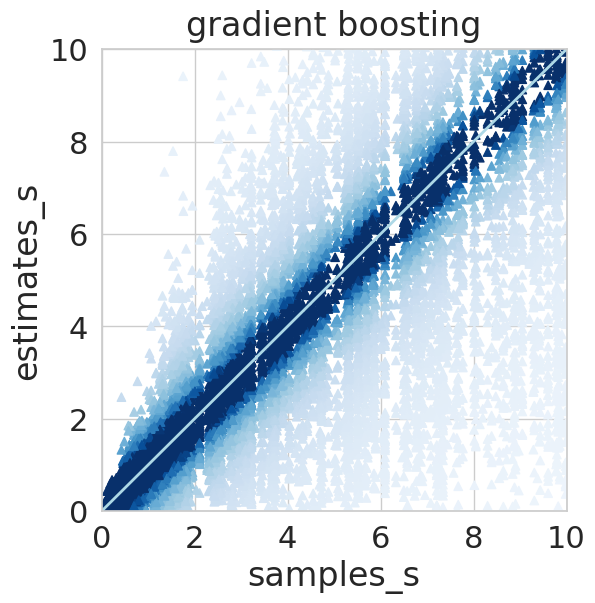

In [70]:
build_estimates_tests_scatter(
    y_test.values,
    tree.predict(X_test), 
    name="gradient boosting", 
    color="blue",
    rang=[0, 10], divider=2, 
    xlabel="samples_s", 
    ylabel="estimates_s"
)